In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Diffusion Monte Carlo

The following implementation is by-the-book. It's supposed to be easy to understand and play with. It simulates an $n$-dimensional quantum harmonic oscillator.

In [4]:
def SHO_3d_single(pos):
    return 0.5 * np.sum(pos**2)

class Walker(object):
    def __init__(self, pos, potential):
        self.pos = np.copy(pos)
        self.V = potential
        
    def step(self, dt, target_energy):
        self.pos += np.sqrt(dt) * np.random.randn(*self.pos.shape)
        q = np.exp(- dt * (self.V(self.pos) - target_energy))
        if q - int(q) > np.random.random(): return 1 + int(q)
        return int(q)
        
class DMC(object):
    def __init__(self, target_nwalkers, potential, dimension=(1,3), target_guess=0.0):
        self.walkers = []
        for ii in xrange(target_nwalkers):
            self.walkers.append(Walker(np.random.random(dimension) - 0.5, potential))
        self.target_energy = target_guess
        self.target_nwalkers = np.float64(target_nwalkers)
        self.V = potential
        
    def timestep(self, dt):
        new_walkers = []
        for walker in self.walkers:
            ncopies = walker.step(dt, self.target_energy)
            for jj in xrange(ncopies):
                new_walkers.append(Walker(walker.pos,self.V))
        self.walkers = new_walkers
        self.target_energy += 0.1*(np.log(self.target_nwalkers/len(self.walkers)))
        return self.target_energy

In [5]:
dd = DMC(300,potential=SHO_3d_single, dimension=(2,3))
es = []
for ii in xrange(900):
     es.append(dd.timestep(0.01))

2.93522944123 0.781060347427


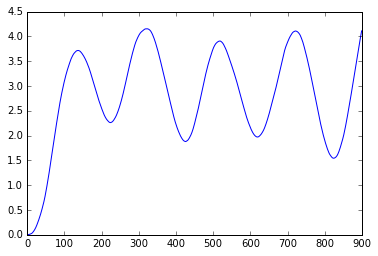

In [6]:
plt.plot(es)
print np.mean(es[200:]), np.std(es[200:])

## Numpy implementation

The big problem with the implementation above is that it does the hard (math) work in little itsy-bitsy pieces, with control logic intermixed. Python loops are slow, branches are slow, and we want to do broad swaths of numerical work before returning to Python. The solution: numpy.

I think this is a good stepping-stone to a GPU implementation. Why? Because it forces us to recast the algorithm in terms of operations on huge blocks of data, rather than on individual walkers or degrees of freedom.

In [7]:
def run_DMC(nsteps, nwalkers, Vfunc, dt, DIM=3, target_guess=0.0):
    sqrt_dt = np.sqrt(dt)
    walkers = np.random.random((nwalkers,DIM)) - 0.5
    target_energy = target_guess
    
    energies = []
    
    for ii in xrange(nsteps):
        walkers += sqrt_dt * np.random.randn(*walkers.shape)
        dv = Vfunc(walkers) - target_energy
        ncopies = np.array(np.exp(-dt*dv) + np.random.random(walkers.shape[0]), dtype=np.int)
        nkeep = walkers[np.flatnonzero(ncopies>0),:]
        ndup  = walkers[np.flatnonzero(ncopies>1),:]
        walkers = np.vstack([nkeep,ndup])        
        target_energy += 0.1*(np.log(nwalkers) - np.log(walkers.shape[0]))
        energies.append(target_energy)
        
    return energies

## Numpy implementation of potentials

The potential function must be rewritten in a vectorized way to take full advantage of the numpy implementation of DMC. For the original implementation, the potential function takes the position of a single walker and returns the energy of that configuration.

What we want is a potential function that takes an matrix of multiple walkers, each row being the position of a single walker, and returns an array of energies: one for each walker.

As a halfway stepping-stone, I've written a function called `vectorize_potential` that will call the single-walker version of a potential in a loop. Using this with the numpy DMC gives a small speed boost over the textbook implementation. More importantly, it can be used to test/debug the fully-vectorized version of a potential.

In [14]:
def SHO_3d_unrolled(posns):
    return 0.5*np.sum(posns**2,axis=1)

def vectorize_potential(potential):
    def vectorized(_posns):
        posns = _posns.reshape((_posns.shape[0],-1))
        answer = np.zeros(posns.shape[0])
        for row in xrange(posns.shape[0]):
            answer[row] = potential(posns[row])
        return answer
    return vectorized

SHO_3d_vectorized = vectorize_potential(SHO_3d_single)
tester = np.random.random((100,3))
assert np.allclose(SHO_3d_unrolled(tester), SHO_3d_vectorized(tester))

In [17]:
ans = run_DMC(nsteps=4000,nwalkers=500,Vfunc=SHO_3d_vectorized,dt=0.01,DIM=3)

1.50550690535 0.393457153373


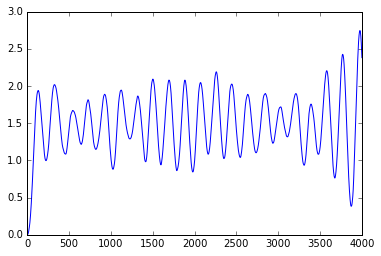

In [18]:
plt.plot(ans)
print np.mean(ans[200:]), np.std(ans[200:])

## Helium

Let's do something more interesting than the harmonic oscillator: the Helium atom. We will compute its ground-state energy. First we'll write its potential function for a single configuration, and use the textbook implementation.

Then we'll write its Hamiltonian in a vectorized fashion so that we can use the faster numpy implementation.

If the errors are too large, we'll have to use importance sampling. This is a good test-case for telling us if we need importance sampling for QDO water dimers.

In [19]:
norm= np.linalg.norm
def Helium_single(_pos):
    # pos: a 2x3 array 
    # containing positions of the 2 electrons
    pos = _pos.reshape((2,3))
    r1,r2,r12 = norm(pos[0]), norm(pos[1]), norm(pos[0]-pos[1])
    return 1/r12 - 2/r1 - 2/r2

In [20]:
dd = DMC(500,potential=Helium_single, dimension=(2,3), target_guess=-2.75)
es = []
for ii in xrange(1000):
     es.append(dd.timestep(0.005))

-2.96590460316 2.72236173245


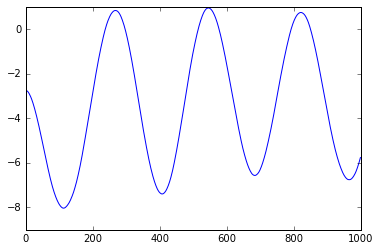

In [21]:
plt.plot(es)
print np.mean(es[200:]), np.std(es[300:])

### Numpy helium

In [22]:
def Helium_unrolled(_pos):
    # pos: an Nx6 array 
    # containing N x positions of the 2 electrons
    pos = _pos.reshape((-1,2,3))
    r1s = norm(pos[:,0,:],axis=1)
    r2s = norm(pos[:,1,:],axis=1)
    r12s = norm(pos[:,0,:] - pos[:,1,:],axis=1)
    return 1/r12s - 2/r1s - 2/r2s
Helium_vectorized = vectorize_potential(Helium_single)
tester = np.random.random((100,6))
assert np.allclose(Helium_vectorized(tester), Helium_unrolled(tester))

-2.85748207495 0.0310671587662
5000 4800


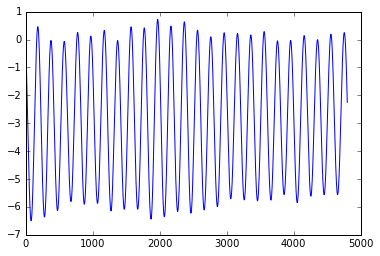

In [33]:
nsteps = int(5e3)
ans = run_DMC(nsteps=nsteps,nwalkers=2000,Vfunc=Helium_unrolled,dt=0.01,DIM=6, target_guess=-2.75)

yans = ans[200:]
print np.mean(yans), np.sqrt(np.var(yans)/nsteps)
print len(ans), len(yans)
plt.plot(yans)

## Jones et al. water model: geometry

Sokhan, Jones, Cipligan's water model uses the geometry from TIP4P, with a quantum drude attached to the virtual site. All charges are diffuse Gaussian charges, and there's a 2-term exponential repulsion between oxygens.

<img src="frame.jpg" width="400">

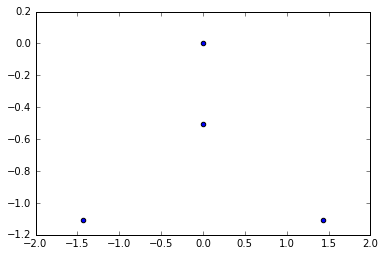

In [36]:
def qdo_water_geometry():
    # returns a 4x3 array of the qdo water frame in a standard reference frame
    # in atomic units ie. in bohrs
    bohr_radius = 0.529 # Angstroms
    R_OH = 0.9572/bohr_radius # Angstroms -> bohrs
    R_OM = 0.2667/bohr_radius # Angstroms -> bohrs
    angle_HOH = 104.52 * np.pi/180 # degrees -> radians
    
    hydrogen_x = R_OH*np.sin(angle_HOH/2)
    hydrogen_y = R_OH*np.cos(angle_HOH/2)
    
    pos = np.zeros((4,3)) # oxygen at 0,0,0
    pos[1] = np.array([hydrogen_x,  -hydrogen_y, 0]) # first hydrogen below it and to the right
    pos[2] = np.array([-hydrogen_x, -hydrogen_y, 0]) # second hydrogen below it and to the left
    pos[3] = np.array([0, -R_OM, 0]) # virtual site directly below oxygen
    
    return pos
p = qdo_water_geometry()
plt.scatter(p[:,[0]], p[:,[1]])

<img src="model.jpg" width="400">

In [86]:
def qdo_water_dimer(U, r):
    # takes a rotation matrix and a vector r
    # returns a water dimer with:
    # first water molecule in standard position
    # second water molecule starts in standard position
    # then rotated by U, then translated by r
    assert np.allclose(U.dot(U.T), np.eye(3))
    pos1 = qdo_water_geometry()
    pos2 = np.array(r).reshape(1,3) + qdo_water_geometry().dot(U)
    return np.vstack([pos1, pos2])

## Jones et al. water model: potential function

### Gaussian charges

(0, 20)

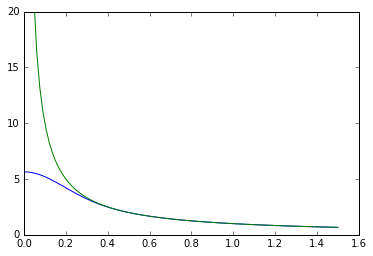

In [160]:
from scipy.special import erf
sqrt_2 = np.sqrt(2)
def diffuse_coulomb(rdist, q1, sigma1, q2, sigma2):
    # returns the diffuse-coulomb energy between
    # 2 charges that are rdist apart, and have the
    # given widths.
    # Input and output are in atomic units: bohrs, 
    # electronic charge, bohrs, and hartrees
    sigma12 = np.sqrt(sigma1**2 + sigma2**2)
    return q1*q2*erf(rdist/(sqrt_2 * sigma12))/rdist

e_coul, e_gauss = [], []
radii = np.linspace(1e-6, 1.5, 100)
for rdist in radii:
    e_coul.append(1./rdist)
    e_gauss.append(diffuse_coulomb(rdist, 1., 0.1, 1., 0.1))

plt.plot(radii, e_gauss)
plt.plot(radii, e_coul)
plt.ylim(0,20)

In [87]:
def qdo_water_dimer_potential(_geometry_arg):
    # returns a function that computes the potential energy
    # for a water dimer with the given geometry, given the
    # positions of the two drudes.    
    geometry_arg = _geometry_arg.reshape((8,3)) 
    water1 = geometry_arg[[0,1,2,3], :]
    water2 = geometry_arg[[4,5,6,7], :]
    
    # first column: charges in units of electron-charge
    # second column: charge-widths in units of bohr
    charge_params = [[-1.21, 1.2],
                     [0.605, 0.1],
                     [0.605, 0.1],
                     [1.1973, 0.1]]    
    norm = np.linalg.norm
    energy_static_coulomb = 0.
    for pos_atom1, param1 in zip(water1, charge_params):
        for pos_atom2, param2 in zip(water2, charge_params):
            r12 = norm(pos_atom1 - pos_atom2)
            q1, sigma1 = param1
            q2, sigma2 = param2
            energy_static_coulomb += diffuse_coulomb(r12, q1, sigma1, q2, sigma2)
    
    def exchange(rdist):
        # returns the exchange-repulsion energy between 
        # two oxygens that are the given distance apart
        K1, K2, lambda1, lambda2 = 2.5, 6000, 1.171802, 2.820276 # hartrees, hartrees, 1/bohr-radius, 1/bohr-radius
        return K1*np.exp(-lambda1*rdist) + K2*np.exp(-lambda2*rdist)
    
    r_O1_O2 = norm(water1[0] - water2[0])
    energy_static_exchange = exchange(r_O1_O2)
    
    energy_static = energy_static_exchange + energy_static_coulomb
    
    drude_mass, drude_omega = 0.3656, 0.6287 # m_e, Hartree/hbar
    drude_q, drude_sigma = -charge_params[3][0], charge_params[3][1]
    def drude_potential(_drudes_geometry):
        drudes_geometry = _drudes_geometry.reshape((2,3))
        drude1_relative = drudes_geometry[0]
        drude2_relative = drudes_geometry[1]
        
        # both positions in terms of displacements from
        # their respective M-sites
        energy_drude_harm = (0.5*drude_mass*drude_omega**2) * (np.sum(drude1_relative**2) + np.sum(drude2_relative**2))
        
        def drude_water_coulomb(drude_pos, water_posns):
            energy_retval = 0.
            for pos_atom1, param1 in zip(water_posns, charge_params):
                r12 = norm(pos_atom1 - drude_pos)
                q1, sigma1 = param1
                energy_retval += diffuse_coulomb(r12, q1, sigma1, drude_q, drude_sigma)
            return energy_retval
        
        drude1_absolute = drude1_relative + water1[3]
        drude2_absolute = drude2_relative + water2[3]
        energy_dynamic_coulomb =  drude_water_coulomb(drude1_absolute, water2) 
        energy_dynamic_coulomb += drude_water_coulomb(drude2_absolute, water1)
        
        r_d1_d2 = norm(drude1_absolute - drude2_absolute)
        energy_dynamic_coulomb += diffuse_coulomb(r_d1_d2, drude_q, drude_sigma, drude_q, drude_sigma)
        
        return energy_dynamic_coulomb + energy_static
    
    return drude_potential

## QDO water dimer: radial scan

First, let's do a scan without moving the drudes at all ie. drudes sitting directly on top of their hosts.

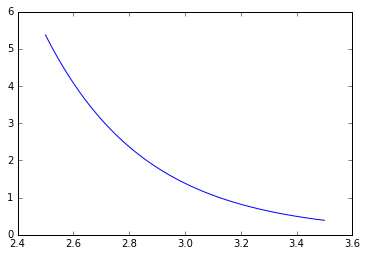

In [88]:
scan = []
unit_vector = np.array([0., 1., 0.])
U = np.eye(3)*-1
xs = np.linspace(2.5,3.5,100)
for xx in xs:
    scan.append(qdo_water_dimer(U, xx*unit_vector))

energies = []
resting_drudes = np.zeros(6)
for dimer in scan:
    potential = qdo_water_dimer_potential(dimer)
    energies.append(potential(resting_drudes))
plt.plot(xs,energies)

Now, let's do DMC on just one point from the scan, to see what's up.

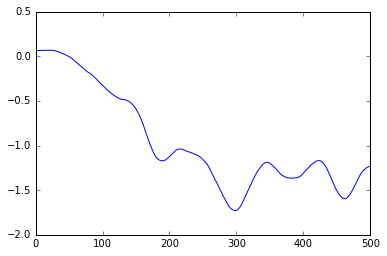

In [89]:
potential = qdo_water_dimer_potential(qdo_water_dimer(np.eye(3), 4.*unit_vector))
dd = DMC(500,potential=potential, dimension=(1,6), target_guess=potential(np.zeros(6)))
es = []
for ii in xrange(500):
     es.append(dd.timestep(0.05))
plt.plot(es)

Now let's use the textbook implementation of DMC on every scan-point.

In [90]:
scan = []
unit_vector = np.array([0., 1., 0.])
U = np.eye(3)
xs = np.linspace(2.5,3.5,10)

for xx in xs:
    scan.append(qdo_water_dimer(U, xx*unit_vector))

energies = []
resting_energies = []
resting_drudes = np.zeros(6)
for dimer in scan:
    potential = qdo_water_dimer_potential(dimer)
    dd = DMC(300,potential=potential, dimension=(1,6), target_guess=potential(resting_drudes))
    es = []
    for ii in xrange(300):
        es.append(dd.timestep(0.05))
    print ".",
    energies.append(es)
    resting_energies.append(potential(resting_drudes))

. . . . . . . . . .


array([ 0.87718484,  0.95015934,  0.88549539,  0.99255612,  1.13869354,
        0.93128676,  0.59869116,  0.99432525,  0.8657957 ,  0.88449629])

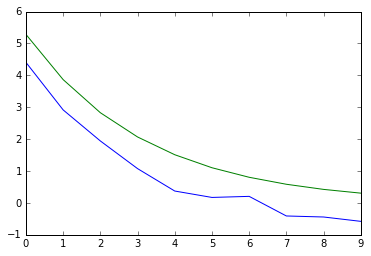

In [91]:
es = np.array(energies)
plt.plot(np.mean(es,axis=1))
plt.plot(resting_energies)
resting_energies - np.mean(es,axis=1)

In [49]:
scan = []
unit_vector = np.array([0., 1., 0.])
U = np.eye(3)
for xx in np.linspace(2.,5.,10):
    scan.append(qdo_water_dimer(U, xx*unit_vector))

energies = []
resting_drudes = np.zeros(6)
for dimer in scan:
    potential = qdo_water_dimer_potential(dimer)
    vectorized = vectorize_potential(potential)
    es = run_DMC(nsteps=1000,nwalkers=500,Vfunc=vectorized,dt=0.05,DIM=6, target_guess=potential(np.zeros(6)))
    print ".",
    energies.append(es)

. . . . . . . . . .


<Container object of 3 artists>

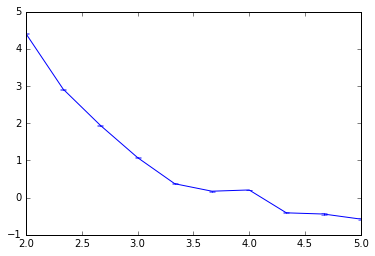

In [92]:
es = np.array(energies)
plt.errorbar(np.linspace(2.,5.,10),np.mean(es,axis=1), yerr = np.sqrt(np.var(es,axis=1)/1000))

## QDO water dimer: rotational scan

The radial scan didn't seem to show much effect due to the drudes. But a rotational scan should show a strong directional hydrogen-bond.

In [93]:
def rotation_scan_matrix(theta):
    st, ct = np.sin(theta), np.cos(theta)
    return np.array([[ct, -st, 0],
                    [st, ct, 0],
                    [0,   0,  1]])

(-2.0, 2.0, -2.0, 6.0)

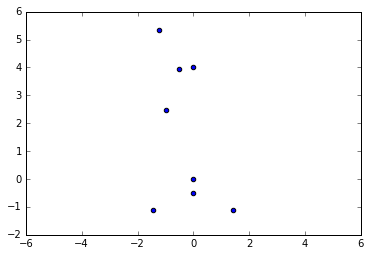

In [144]:
angle = 85. # degrees
distance = 4. # bohrs

m = rotation_scan_matrix(angle * np.pi/180)
p = qdo_water_dimer(m, [0, distance, 0])
plt.scatter(p[:,0], p[:,1])
plt.axis('equal')

In [156]:
angles_fine = np.linspace(-10, 130, 100)

resting_drudes = np.zeros(6)
resting_energies = []
for angle in angles_fine:
    U = rotation_scan_matrix(angle * np.pi/180)
    dimer = qdo_water_dimer(U, [0, distance, 0])
    potential = qdo_water_dimer_potential(dimer)
    resting_energies.append(potential(resting_drudes))

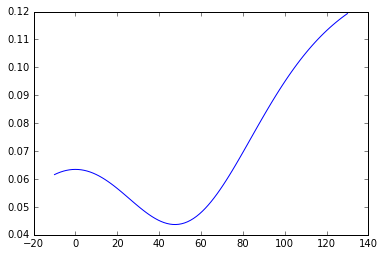

In [157]:
plt.plot(angles_fine, resting_energies)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

<Container object of 3 artists>

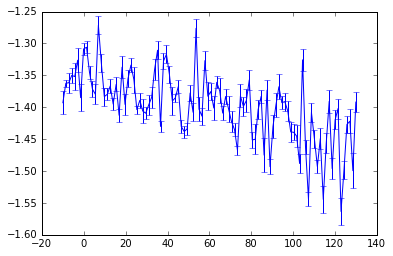

In [159]:
angles_coarse = np.linspace(-10, 130, 100)
nwalkers, nsteps = 1000, 1000


resting_drudes = np.zeros(6)
energies = []

for angle in angles_coarse:
    U = rotation_scan_matrix(angle * np.pi/180)
    dimer = qdo_water_dimer(U, [0, distance, 0])
    potential = qdo_water_dimer_potential(dimer)
    
    vectorized = vectorize_potential(potential)
    es = run_DMC(nsteps=nsteps,nwalkers=nwalkers,Vfunc=vectorized,dt=0.05,DIM=6, target_guess=potential(np.zeros(6))-0.4)
    print ".",
    energies.append(es[100:])
energies = np.array(energies)
plt.errorbar(angles_coarse, np.mean(energies,axis=1), yerr = np.sqrt(np.var(energies,axis=1)/nsteps))
#plt.plot(angles_fine, resting_energies)

In [166]:
import pickle
pickle.dump((nsteps, nwalkers, angles_coarse, energies), file("2xO.rotational-scan.pickle", "w"))